In [1]:
import os
import gc
import time
import pickle
from pathlib import Path
import numpy as np
import pandas as ps

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_folder = Path('..') / 'data'

In [3]:
with open(str(data_folder / 'processed' / 'train_12.pkl'), 'rb') as f:
    train_df = pickle.load(f)
    
print('Train shapes:', train_df.shape)

Train shapes: (354851, 210)


In [4]:
with open(str(data_folder / 'processed' / 'test_12.pkl'), 'rb') as f:
    test_df = pickle.load(f)

print('Test shapes:', test_df.shape)

Test shapes: (202614, 209)


In [5]:
target = 'CancelFlag'
drop_features = [
    'OrderID', 
    'Date_day', 
    'Date_year',
    'OrderDate_day', 
    'OrderDate_year',
    target,
]
features2use = [f for f in train_df.columns if not any(f.startswith(df) for df in drop_features)]
categorical_features = []

In [6]:
len(features2use)

208

In [7]:
test_df[target] = 0
# train_df = train_df.iloc[:5_000]

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(
        ax.get_xticklabels(), 
        rotation=45, 
        ha="right",
        rotation_mode="anchor"
    )

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(b=None)
    plt.show(fig)

In [9]:
def make_predictions(folds, 
                     train_dframe, 
                     test_dframe, 
                     model_params,
                     features,
                     target,
                     n_estimators=50_000, n_jobs=12, 
                     verbose=10_000, early_stopping_rounds=200):

    X, y = train_dframe[features], train_dframe[target]    
    P = test_dframe[features]
    num_folds = folds.n_splits
    
    oof_preds = np.zeros((len(train_dframe), 1))
    predictions = np.zeros((len(test_dframe), 1))
    
    feature_importance = ps.DataFrame.from_dict({
        'feature': features2use,
        'importance': np.zeros(len(features2use))
    })
    scores = []
    
    for fold_, (train_idx, valid_idx) in enumerate(folds.split(X, y.values)):
        print()
        print(f'[{time.ctime()}] Fold: {fold_ + 1}/{num_folds}', flush=True)
        
        train_x, train_y = X.iloc[train_idx,:], y.iloc[train_idx]
        valid_x, valid_y = X.iloc[valid_idx,:], y.iloc[valid_idx]
        print('Train & val shapes -', len(train_x), len(valid_y), flush=True)
        
#         pos_weight = np.sum(train_y == 0) / np.sum(train_y == 1)
#         pos_weight *= 1e5
#         print(f'Positive weight - {pos_weight}')
        
        model = xgb.XGBClassifier(
            **model_params, 
            n_estimators=n_estimators, 
            n_jobs=n_jobs,
#             scale_pos_weight=pos_weight,
        )
        model.fit(
            train_x, train_y,
            eval_set=[(train_x, train_y), (valid_x, valid_y)],
            early_stopping_rounds=early_stopping_rounds,
            verbose=verbose,
#             categorical_feature=categorical_features
        )
        feature_importance['importance'] += model.feature_importances_ / num_folds
        
        valid_preds = model.predict_proba(valid_x)[:, 1]
        oof_preds[valid_idx] = valid_preds.reshape(-1, 1)
        
        valid_pred_cls = model.predict(valid_x)
        print()
        print(classification_report(valid_y, valid_pred_cls))
        plot_confusion_matrix(valid_y, valid_pred_cls, classes=[f'not {target}', target], normalize=True)
        scores.append(roc_auc_score(valid_y.values, valid_preds))
        
        test_preds = model.predict_proba(P)[:, 1]
        predictions += test_preds.reshape(-1, 1)
    
    test_dframe[target] = predictions / num_folds
    
    print()
    print(f'Folds score - {np.mean(scores):.6f} +- {np.std(scores):.6f}', flush=True)
    print()
    
    return test_dframe, oof_preds, feature_importance

In [10]:
params = {
#     'num_leaves': 491,
#     'min_child_weight': 0.03454472573214212,
#     'feature_fraction': 0.3797454081646243,
#     'bagging_fraction': 0.4181193142567742,
#     'min_data_in_leaf': 106,
    'objective': 'binary:logistic',
#     'max_depth': 1_000,
    'learning_rate': 0.005,
    'boosting_type': 'gbtree',
    'bagging_seed': 11,
    'eval_metric': 'auc',
    'verbosity': 0,
#     'reg_alpha': 0.3899927210061127,
#     'reg_lambda': 0.6485237330340494,
    'random_state': 47,
}
folds = StratifiedKFold(n_splits=7, random_state=2019)
# folds = KFold(n_splits=7, random_state=2019)


[Sun Nov 24 23:47:34 2019] Fold: 1/7
Train & val shapes - 304157 50694
[0]	validation_0-auc:0.641411	validation_1-auc:0.614396
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[5000]	validation_0-auc:0.87882	validation_1-auc:0.854081
[10000]	validation_0-auc:0.895144	validation_1-auc:0.873294
[15000]	validation_0-auc:0.903976	validation_1-auc:0.879331
Stopping. Best iteration:
[15384]	validation_0-auc:0.904533	validation_1-auc:0.87955


              precision    recall  f1-score   support

           0       0.95      0.99      0.97     47297
           1       0.79      0.28      0.41      3397

    accuracy                           0.95     50694
   macro avg       0.87      0.64      0.69     50694
weighted avg       0.94      0.95      0.93     50694



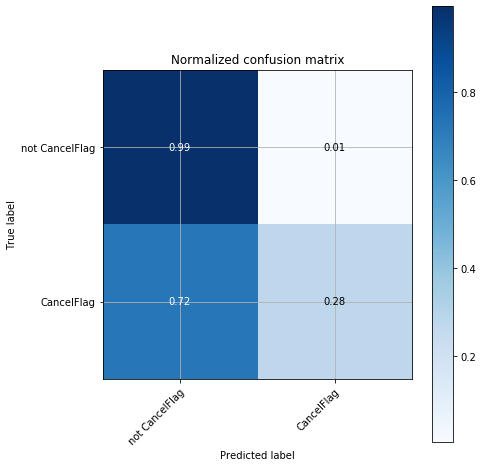


[Mon Nov 25 00:26:56 2019] Fold: 2/7
Train & val shapes - 304157 50694
[0]	validation_0-auc:0.63861	validation_1-auc:0.651542
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[5000]	validation_0-auc:0.878532	validation_1-auc:0.864271
[10000]	validation_0-auc:0.895124	validation_1-auc:0.87626
[15000]	validation_0-auc:0.903919	validation_1-auc:0.881799
[20000]	validation_0-auc:0.910177	validation_1-auc:0.884526
[25000]	validation_0-auc:0.915198	validation_1-auc:0.886274
[30000]	validation_0-auc:0.919401	validation_1-auc:0.887537
[35000]	validation_0-auc:0.923008	validation_1-auc:0.888301
[40000]	validation_0-auc:0.926255	validation_1-auc:0.888921
[45000]	validation_0-auc:0.929194	validation_1-auc:0.889313
[49999]	validation_0-auc:0.932016	validation_1-auc:0.889583

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     47297
       

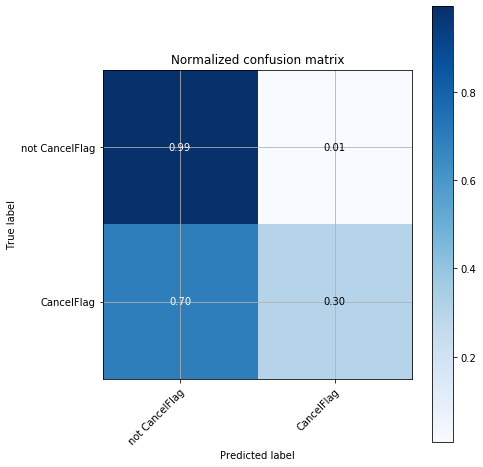


[Mon Nov 25 02:30:23 2019] Fold: 3/7
Train & val shapes - 304157 50694
[0]	validation_0-auc:0.640098	validation_1-auc:0.642432
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
Stopping. Best iteration:
[2264]	validation_0-auc:0.852989	validation_1-auc:0.841911


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     47297
           1       0.96      0.08      0.15      3397

    accuracy                           0.94     50694
   macro avg       0.95      0.54      0.56     50694
weighted avg       0.94      0.94      0.91     50694



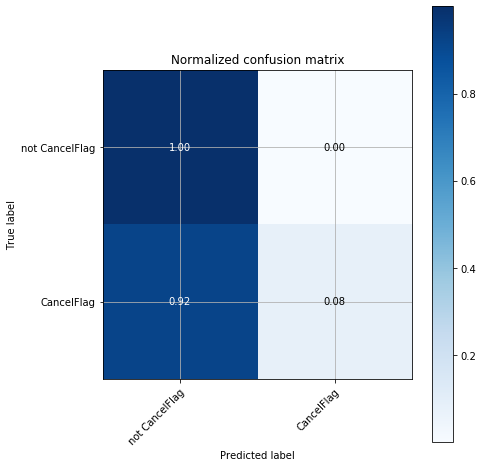


[Mon Nov 25 02:37:19 2019] Fold: 4/7
Train & val shapes - 304158 50693
[0]	validation_0-auc:0.638716	validation_1-auc:0.65058
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[5000]	validation_0-auc:0.87694	validation_1-auc:0.875286
[10000]	validation_0-auc:0.89364	validation_1-auc:0.887749
[15000]	validation_0-auc:0.9027	validation_1-auc:0.892637
[20000]	validation_0-auc:0.90881	validation_1-auc:0.89497
[25000]	validation_0-auc:0.913882	validation_1-auc:0.896195
[30000]	validation_0-auc:0.918242	validation_1-auc:0.896677
[35000]	validation_0-auc:0.921958	validation_1-auc:0.897309
Stopping. Best iteration:
[34629]	validation_0-auc:0.921708	validation_1-auc:0.897343


              precision    recall  f1-score   support

           0       0.95      1.00      0.97     47296
           1       0.84      0.32      0.46      3397

    accuracy                           0.95     50

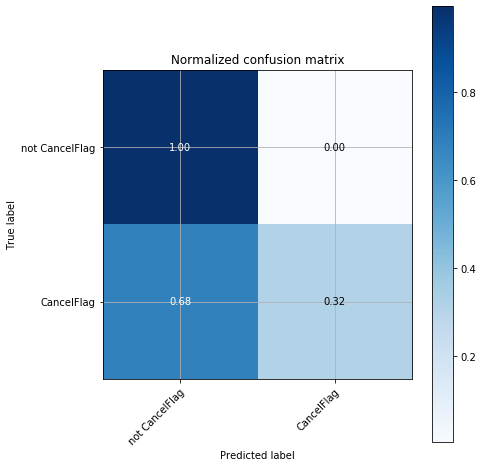


[Mon Nov 25 04:04:15 2019] Fold: 5/7
Train & val shapes - 304159 50692
[0]	validation_0-auc:0.640766	validation_1-auc:0.638255
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
Stopping. Best iteration:
[1456]	validation_0-auc:0.82951	validation_1-auc:0.804034


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     47296
           1       1.00      0.08      0.14      3396

    accuracy                           0.94     50692
   macro avg       0.97      0.54      0.56     50692
weighted avg       0.94      0.94      0.91     50692



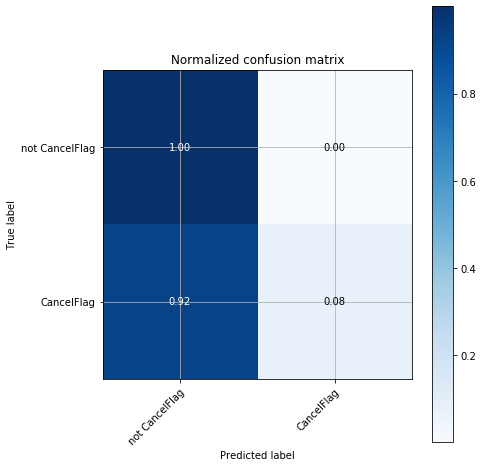


[Mon Nov 25 04:09:11 2019] Fold: 6/7
Train & val shapes - 304159 50692
[0]	validation_0-auc:0.640414	validation_1-auc:0.640884
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
Stopping. Best iteration:
[899]	validation_0-auc:0.79012	validation_1-auc:0.792978


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     47296
           1       1.00      0.05      0.10      3396

    accuracy                           0.94     50692
   macro avg       0.97      0.53      0.53     50692
weighted avg       0.94      0.94      0.91     50692



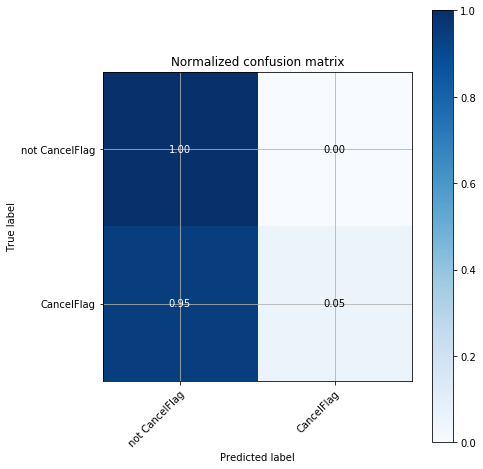


[Mon Nov 25 04:12:46 2019] Fold: 7/7
Train & val shapes - 304159 50692
[0]	validation_0-auc:0.640746	validation_1-auc:0.638812
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 500 rounds.
[5000]	validation_0-auc:0.880232	validation_1-auc:0.856796
[10000]	validation_0-auc:0.897305	validation_1-auc:0.865676
[15000]	validation_0-auc:0.906331	validation_1-auc:0.869525
[20000]	validation_0-auc:0.912571	validation_1-auc:0.871483
Stopping. Best iteration:
[20237]	validation_0-auc:0.912804	validation_1-auc:0.87154


              precision    recall  f1-score   support

           0       0.95      0.99      0.97     47296
           1       0.62      0.30      0.41      3396

    accuracy                           0.94     50692
   macro avg       0.78      0.65      0.69     50692
weighted avg       0.93      0.94      0.93     50692



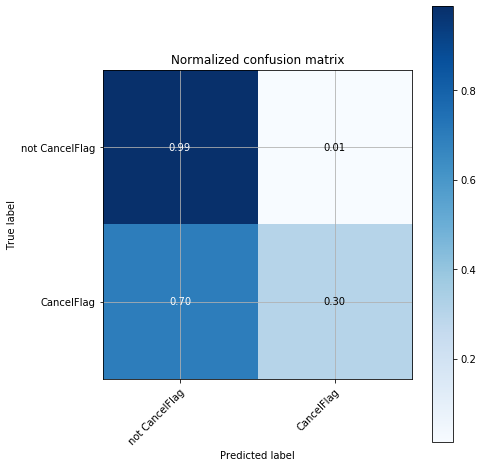


Folds score - 0.853849 +- 0.038677

CPU times: user 2d 14h 57min 14s, sys: 6min 5s, total: 2d 15h 3min 19s
Wall time: 5h 16min 24s


In [11]:
%%time

test_df, oof_preds, fi = make_predictions(
    folds, 
    train_df, 
    test_df,
    params,
    features=features2use,
    target=target,
    n_jobs=os.cpu_count(), 
    verbose=5_000, 
    early_stopping_rounds=500
)

In [12]:
fi = fi.sort_values(by='importance', ascending=False)

In [13]:
fi[fi['importance'] == 0]['feature'].tolist()

['Cluster_26',
 'PrevNumMaterialsByMonth|mean',
 'PrevNumGroupMaterialsByDay|mean',
 'DiffWithPrevNumMaterialsByMonth|mean',
 'NumMaterialsByMonth|mean',
 'Cluster_27',
 'StartInterval_16',
 'Cluster_28',
 'Cluster_29',
 'NumGroupMaterialsByDay|mean',
 'Cluster_25',
 'GroupID_44',
 'GroupID_48',
 'DiffWithPrevNumGroupMaterialsByDay|mean',
 'NumGroupMaterialsByMonth|mean',
 'MaterialsCnt|max',
 'PrevNumGroupMaterialsByMonth|mean',
 'MaterialsCnt|min',
 'MaterialsCnt',
 'MaterialsCnt|mean',
 'HasPreviousOrder_y|mean',
 'DiffWithPrevNumGroupMaterialsByMonth|mean',
 'NumUniqueMaterialsByOrder|mean',
 'PrevNumUniqueMaterialsByOrder|mean',
 'DiffWithPrevNumUniqueMaterialsByOrder|mean',
 'HasPreviousOrder_x|mean',
 'MaterialsCnt|std']

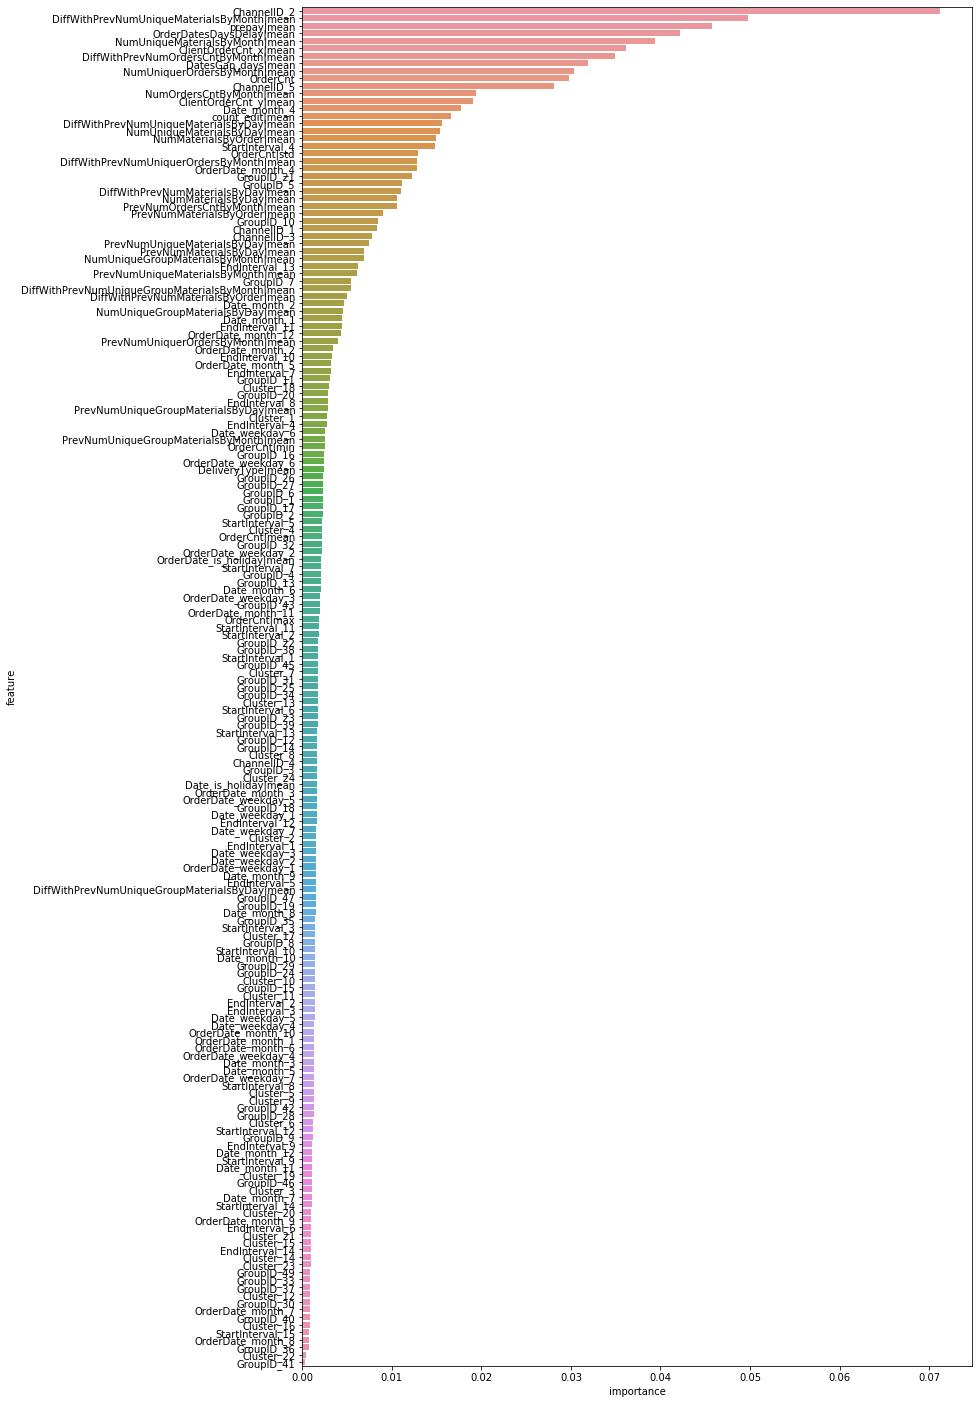

In [14]:
plt.figure(figsize=(12, 25))
sbn.barplot(x='importance', y='feature', data=fi[fi['importance'] > 0]);

In [15]:
fi.to_csv('xgb_feature_importance.csv', index=False)

In [16]:
t = test_df.copy()

res = t.groupby('OrderID').agg({'CancelFlag': 'mean'}).reset_index().rename(columns={'OrderID': 'ID', 'CancelFlag': 'Score'})
res['ID'] = res['ID'].map(lambda item: f'{item} ')
print(res.shape)
res.head()

(202614, 2)


,ID,Score
0,90102211131,0.070540
1,90102211133,0.040089
2,90102216055,0.163685
3,90102216081,0.162892
4,90102216084,0.151543


In [17]:
empty_df = ps.read_csv(data_folder / 'empty.csv')
print(empty_df.shape)
empty_df.head()

(202614, 2)


,ID,Score
0,90102211131,0.5
1,90102211133,0.5
2,90102216055,0.5
3,90102216081,0.5
4,90102216084,0.5


In [18]:
res.to_csv('../submission/xgbm_sub.csv', index=False)